```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
from SWESimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, PlotHelper

In [2]:
import atexit
def exitfunc():
    #Clean up old context if any:
    if 'cuda_context' in globals():
        print("Deleting existing context")
        global cuda_context
        del cuda_context
        gc.collect()
    else:
        print("No existing CUDA context")
        gc.collect()
        
atexit.register(exitfunc)
exitfunc()
    
cuda_context = Common.CudaContext(verbose=True, blocking=False)

No existing CUDA context
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <30193326240>


In [3]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [4]:
def save_figure(fig, stem):
    fig_filename = "convergence_smooth2d_" + stem + ".pdf"
    
    image_text = fig_filename + "\nCreated " + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    #ax = fig.gca()
    #pos1 = ax.get_position() # get the original position 
    #pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 
    #ax.set_position(pos2) # set a new position
    
    #fig.gca().annotate(image_text, xy=(1.1, 0), xycoords='figure fraction', fontsize=10,
    #                   horizontalalignment='right', verticalalignment='bottom')
    t = plt.figtext(-0.1, .9, image_text, rotation='vertical')
    
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, bbox_extra_artists=(legend,t, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename)

In [5]:
def downsample(highres_solution, factor):
    assert(highres_solution.shape[0] % factor == 0)
    assert(highres_solution.shape[1] % factor == 0)
    ny = highres_solution.shape[0] / factor
    nx = highres_solution.shape[1] / factor
    
    if (factor == 1):
        return highres_solution
    else:
        return highres_solution.reshape([int(ny), int(factor), int(nx), int(factor)]).mean(3).mean(1)

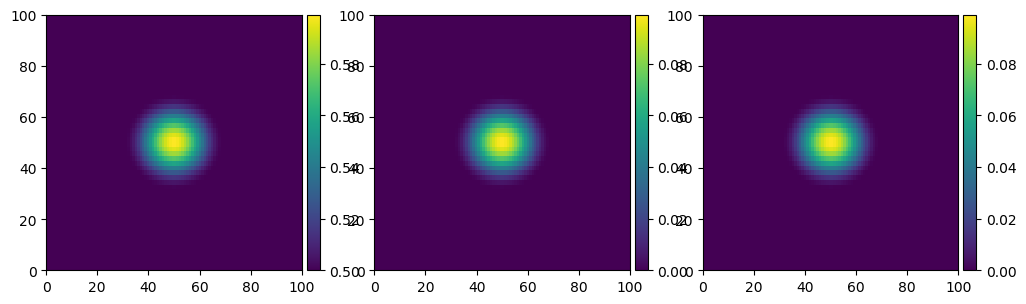

[1.0, 2.0, 0.2726356370001644]


In [6]:
def wall_boundary_conditions(data):
    data[0:2,:] = data[4:2:-1,:]
    data[-2:,:] = data[-3:-5:-1,:]
    data[:,0:2] = data[:,4:2:-1]
    data[:,-2:] = data[:,-3:-5:-1]
    return data
    

def gen_test_data(nx, ny, ref_nx, ref_ny, g, num_ghost_cells):
    width = 100.0
    height = 100.0
    ref_dx = width / float(ref_nx)
    ref_dy = height / float(ref_ny)

    x_center = ref_dx*ref_nx/2.0
    y_center = ref_dy*ref_ny/2.0

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10**10
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    
    x = ref_dx*(np.arange(0, ref_nx, dtype=np.float32)+0.5) - x_center
    y = ref_dy*(np.arange(0, ref_ny, dtype=np.float32)+0.5) - y_center
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    r = np.sqrt(xv**2 + yv**2)
    xv = None
    yv = None
    gc.collect()
    
    #Make sure that the wanted resolution is suitable
    assert(ref_nx >= nx)
    assert(ref_ny >= ny)
    assert(nx/ref_nx == ny/ref_ny)
    
    #Generate highres then downsample
    #h_highres = 0.5 + 0.1*np.exp(-(xv**2/size + yv**2/size))
    h_highres = 0.5 + 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    h[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(h_highres, ref_nx/nx)
    h_highres = None
    gc.collect()
    
    #hu_highres = 0.1*np.exp(-(xv**2/size + yv**2/size))
    hu_highres = 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    hu[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(hu_highres, ref_nx/nx)
    hu_highres = None
    gc.collect()
    
    #hv_highres = 0.1*np.exp(-(xv**2/size + yv**2/size))
    hv_highres = 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    hv[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(hv_highres, ref_nx/nx)
    hv_highres = None
    gc.collect()
    
    #Fix boundary conditions
    h = wall_boundary_conditions(h);
    hu = wall_boundary_conditions(hu);
    hv = wall_boundary_conditions(hv);
    
    scale = 0.7
    max_h_estimate = 0.6
    max_u_estimate = 0.1*np.sqrt(2.0)
    dx = width/nx
    dy = height/ny
    dt = scale * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

h, hu, hv, dx, dy, dt = gen_test_data(nx=100, ny=50, ref_nx=1000, ref_ny=500, g=9.81, num_ghost_cells=2)

plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,2)
im=plt.imshow(hu, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,3)
im=plt.imshow(hv, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

print([dx, dy, dt])

In [7]:
def gen_filename(simulator, nx):
    return "shock1d_" + str(simulator.__name__) + "_" + str(nx) + ".npz"

In [8]:
def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) or np.isnan(minval)):
        print("=== WARNING ===")
        print(variable_name + " contains NaN values")
        print("=== WARNING ===")

def run_benchmark(simulator, courant_number, nx, ny, ref_nx, ref_ny, num_ghost_cells, g=9.81, force_rerun=False, datafilename=None):

    if (datafilename and os.path.isfile(datafilename) and force_rerun == False):
        print("=== WARNING ===")
        print("Existing simulation exists, skipping simulation")
        print("=== WARNING ===")
        return[0, 0, 0]
    else:
        #Generate high-res initial conditions
        h0, hu0, hv0, dx, dy, dt = gen_test_data(nx=nx, ny=ny, ref_nx=ref_nx, ref_ny=ref_ny, g=g, num_ghost_cells=num_ghost_cells)
        dt = dt * courant_number

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            sim = simulator(cuda_context, \
                            h0, hu0, hv0, \
                            nx, ny, \
                            dx, dy, dt, \
                            g)

            t, nt = sim.simulate(1.0)
            
            h, hu, hv = sim.download()

        h = h[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells]
        hu = hu[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells]
        hv = hv[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells]

        sanity_check(h, "h")
        sanity_check(hu, "hu")
        sanity_check(hv, "hv")

        if (datafilename):
            np.savez_compressed(datafilename, h=h, hu=hu, hv=hv, nt=nt, t=t, elapsed=timer.secs)
        else:
            print("=== WARNING ===")
            print("No datafilename supplied - no data saved to disk!")
            print("=== WARNING ===")
            
        
    gc.collect() # Force run garbage collection to free up memory
    
    return [timer.secs, nt, dt]

=> KP07_50 7458.797216 ms


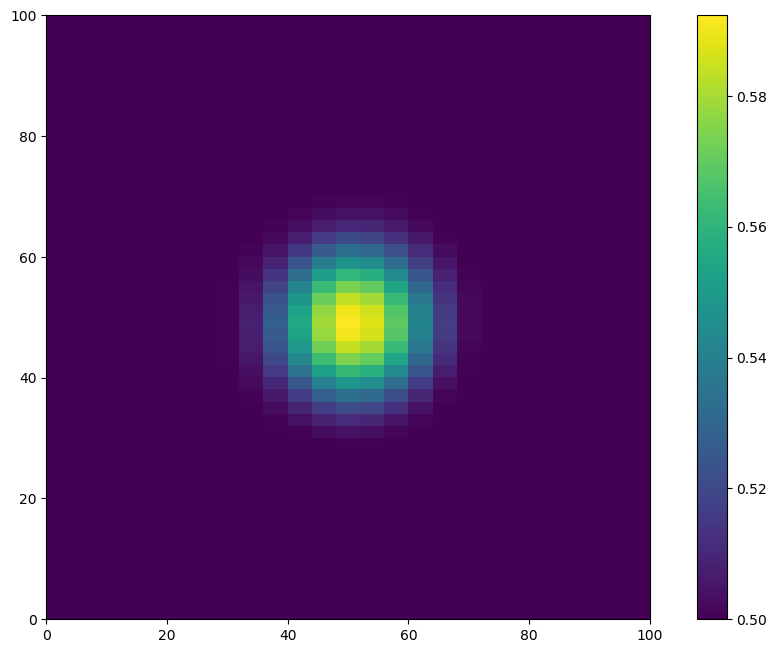

3359

In [9]:
datafilename = "temp_data.npz"
elapsed, nt, dt = run_benchmark(KP07.KP07, 
                                courant_number=0.9, 
                                ref_nx=500, ref_ny=1000,
                                nx=50, ny=100, 
                                num_ghost_cells=2, force_rerun=True,
                                datafilename=datafilename)

with np.load(datafilename) as data:
    rh = downsample(data['h'], 2)

    plt.figure()
    plt.imshow(rh, extent=[0, 100, 0, 100])
    plt.colorbar()
    plt.show()
    
gc.collect()

In [10]:
reference_nx = 2048
force_rerun=True
domain_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07', 'KP07 dimsplit']
simulator_courant_numbers = [0.9, 0.9, 0.9, 0.9, 0.9, 0.45, 0.9]



sim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
sim_dt = np.zeros((len(simulators), len(domain_sizes)))
sim_nt = np.zeros((len(simulators), len(domain_sizes)))

#Warmup to compile kernels
with Common.Timer("warmup", verbose=False) as timer:
    for i in range(len(simulators)):
        run_benchmark(simulator=simulators[i], 
                      courant_number=simulator_courant_numbers[i], 
                      nx=16, ny=16, ref_nx=16, ref_ny=16,
                      num_ghost_cells=simulator_ghost_cells[i], 
                      force_rerun=force_rerun)
print("Completed warmup in {:} s".format(timer.secs))
    
with Common.Timer("simulation", verbose=False) as timer:
    for i in range(len(simulators)):        
        # Run the simulation for all the domain sizes
        for j, nx in enumerate(domain_sizes):
            datafilename = gen_filename(simulators[i], nx)
            [secs, nt, dt] = run_benchmark(simulator=simulators[i], 
                          courant_number=simulator_courant_numbers[i], 
                          nx=nx, ny=nx, ref_nx=reference_nx, ref_ny=reference_nx,
                          num_ghost_cells=simulator_ghost_cells[i], 
                          force_rerun=force_rerun, 
                          datafilename=datafilename)
            sim_elapsed_time[i, j] = secs
            sim_dt[i, j] = dt
            sim_nt[i, j] = nt

        # Run reference with a low CFL-number
        datafilename = gen_filename(simulators[i], reference_nx)
        run_benchmark(simulator=simulators[i], 
                      courant_number=simulator_courant_numbers[i], 
                      nx=reference_nx, ny=reference_nx, ref_nx=reference_nx, ref_ny=reference_nx,
                      num_ghost_cells=simulator_ghost_cells[i], 
                      force_rerun=force_rerun, 
                      datafilename=datafilename)
print("Completed simulation in {:} s".format(timer.secs))

=> LxF_16 5302.073002 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
=> FORCE_16 5737.286806 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
=> HLL_16 5324.382305 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
=> HLL2_16 6712.691545 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
=> WAF_16 5922.235012 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
=> KP07_16 18.040895 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
=> KP07_dimsplit_16 6507.807493 ms
=== WARNING ===
No datafilename supplied - no data saved to disk!
=== WARNING ===
Completed warmup in 37.869147539138794 s
=> LxF_8 16.005754 ms
=> LxF_16 11.012316 ms
=> LxF_32 12.008667 ms
=> LxF_64 9.007454 ms
=> LxF_128 9.007454 ms
=> LxF_256 17.012358 ms
=> LxF_512 52.036047 ms
=> LxF_1024 278.194666 ms
=> LxF_2048

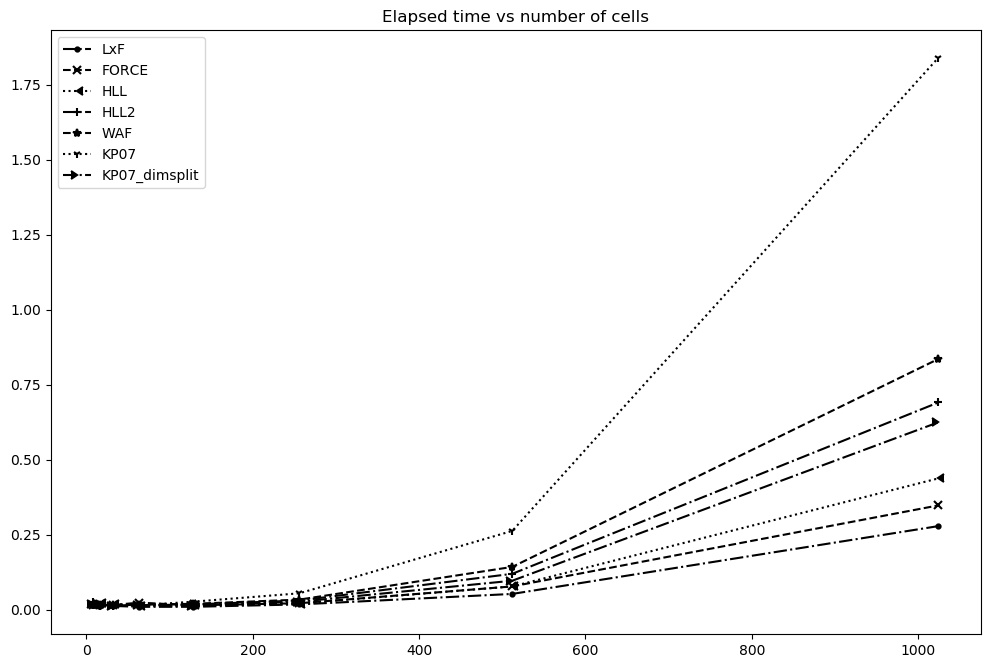

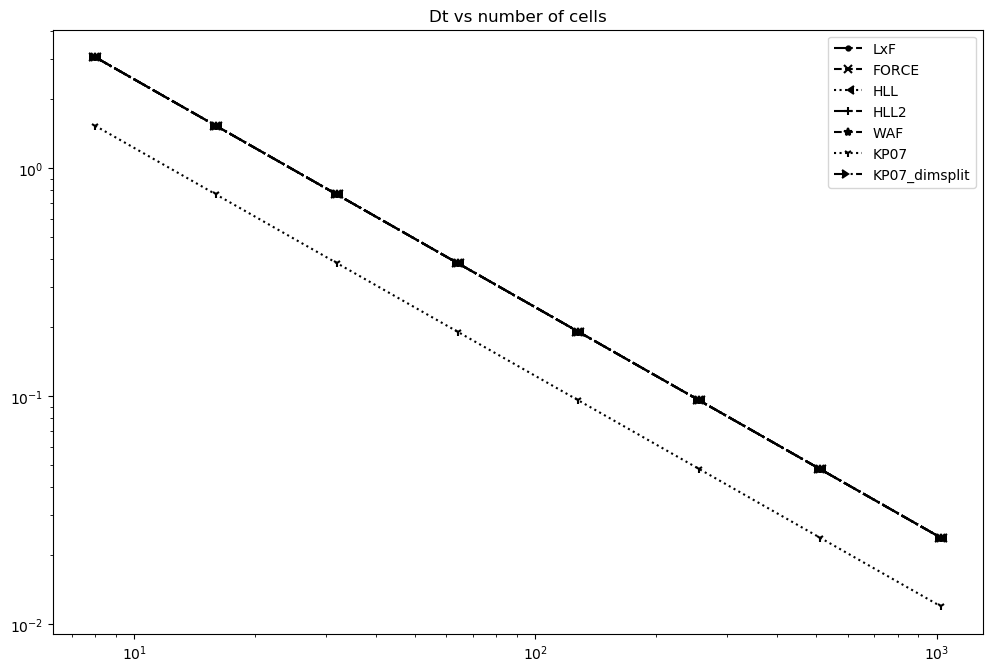

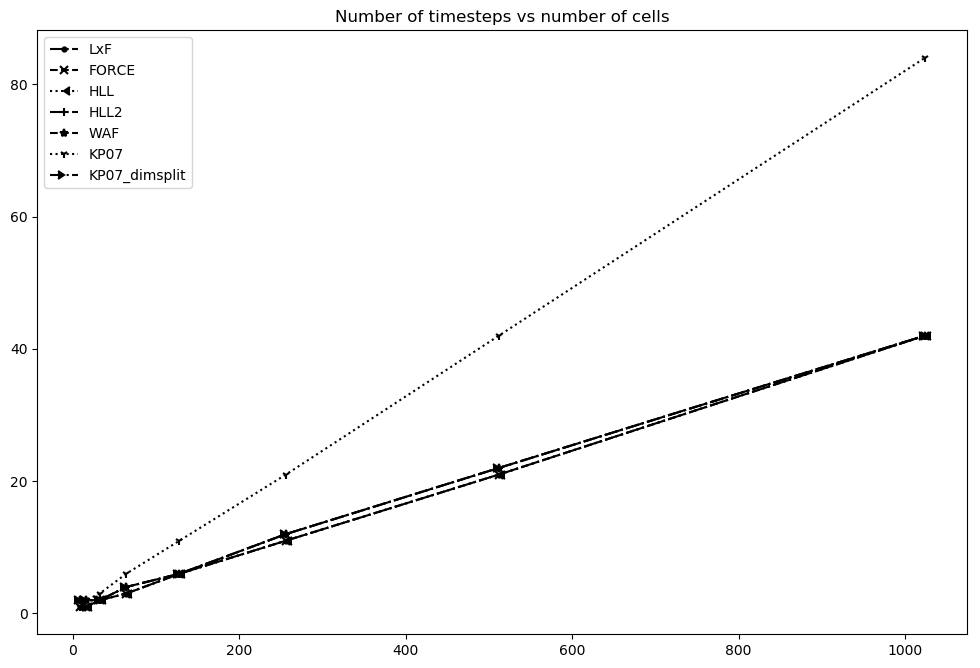

In [11]:
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Elapsed time vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_elapsed_time[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Dt vs number of cells")
for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, sim_dt[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Number of timesteps vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_nt[i,:], label=simulator.__name__)
plt.legend()

In [12]:
import pandas as pd
from IPython.display import display

conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))
order = np.zeros((len(simulators), len(domain_sizes)-1))

for i, simulator in enumerate(simulators):
    #Read the reference solution
    datafilename = gen_filename(simulator, reference_nx)
    with np.load(datafilename) as data:
        h_ref = data['h']
    
    #Compute conservation and error for subsequent resolutions
    for j, nx in enumerate(domain_sizes):
        #Read current resolution
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h']
        
        #Downsample reference to current resolution
        h_ref_downsampled = downsample(h_ref, reference_nx/nx)
        
        #Compute error per cell
        error[i, j] = np.linalg.norm((h_ref_downsampled - h).flatten(), ord=1) / (nx*nx)
        conservation[i, j] = (np.sum(h_ref_downsampled) - np.sum(h))
    
    #Compute the numerical order
    a = np.arange(1, len(domain_sizes))
    order[i,:] = np.log2(error[i, :-1] / error[i, 1:])


table = pd.DataFrame(order, columns=domain_sizes[:-1], index=[simulator.__name__ for simulator in simulators])
display(table)

order_summary = pd.DataFrame(np.empty((len(simulators), 4)), columns=['Max', 'Min', 'Mean', 'Stdev'], index=[simulator.__name__ for simulator in simulators])
for i, simulator in enumerate(simulators):
    order_summary.loc[simulator.__name__] = [np.max(order[i,:]), 
        np.min(order[i,:]), 
        np.mean(order[i,:]), 
        np.std(order[i,:])]
display(order_summary)

,8,16,32,64,128,256,512
LxF,2.109998,1.117344,1.770541,1.130174,1.398593,1.459872,1.585554
FORCE,1.803550,1.058752,1.424818,0.994047,1.264049,1.354103,1.598773
HLL,1.271458,1.218233,1.018041,1.023368,1.120194,1.259487,1.649370
HLL2,2.011525,2.450778,0.885168,0.590706,0.819484,1.128430,2.156802
WAF,2.016446,2.483785,1.021645,0.705272,0.891656,0.858559,2.275014
KP07,1.560495,2.067524,1.738482,2.077667,2.065662,2.206142,2.172162
KP07_dimsplit,1.896522,2.258217,1.073543,0.676780,0.846475,1.155170,2.138188


,Max,Min,Mean,Stdev
LxF,2.109998,1.117344,1.510297,0.326663
FORCE,1.803550,0.994047,1.356870,0.265059
HLL,1.649370,1.018041,1.222879,0.199257
HLL2,2.450778,0.590706,1.434699,0.694177
WAF,2.483785,0.705272,1.464625,0.703906
KP07,2.206142,1.560495,1.984019,0.222584
KP07_dimsplit,2.258217,0.676780,1.434985,0.599449


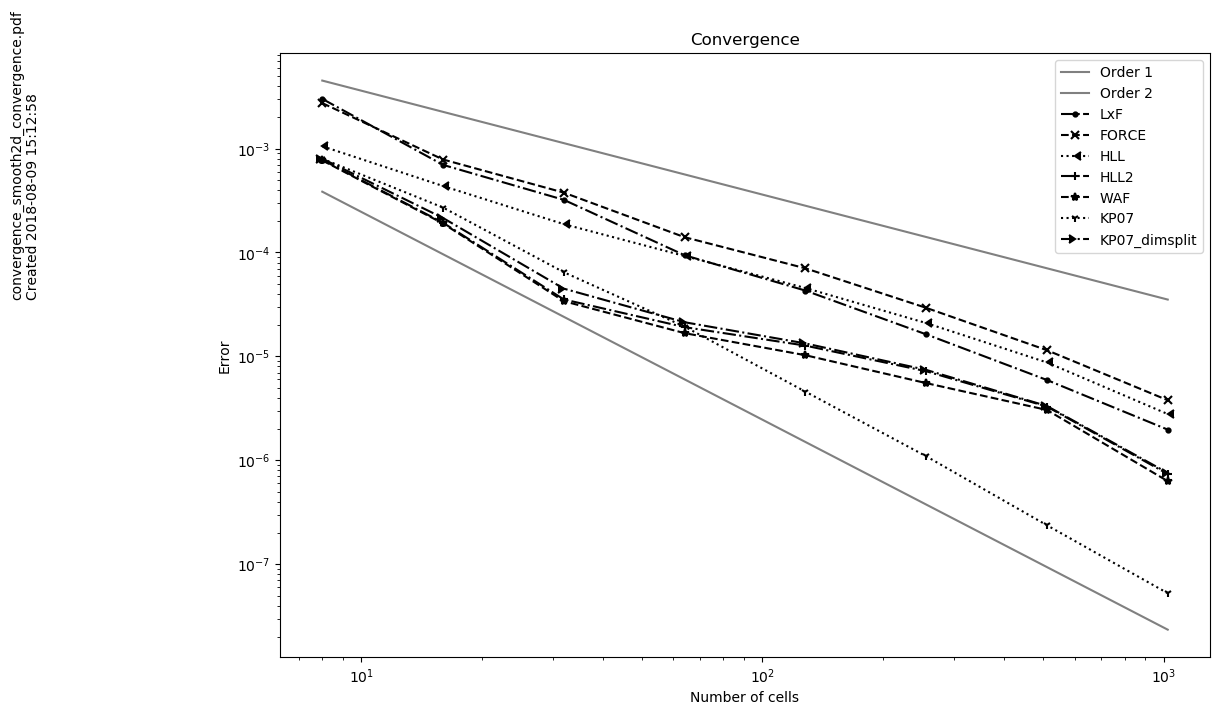

In [13]:
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.max(error[:,0]) * domain_sizes[0] * 1.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, error[i,:], label=simulators[i].__name__)

plt.xlabel('Number of cells')
plt.ylabel('Error')
plt.title("Convergence")
plt.legend()
save_figure(fig, 'convergence')

In [14]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        h = h[int(nx/2),:]
        
    x = np.linspace(0.5, nx-0.5, nx)*100.0/float(nx)
    
    plt.plot(x, h, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force run garbage collection to free up memory
    
def plot_comparison(nx, **kwargs):
    plot_solution(HLL2.HLL2, reference_nx, 'Reference', marker=' ', linestyle='-')

    for i, simulator in enumerate(simulators):
        plot_solution(simulator, nx, simulator.__name__, **kwargs)

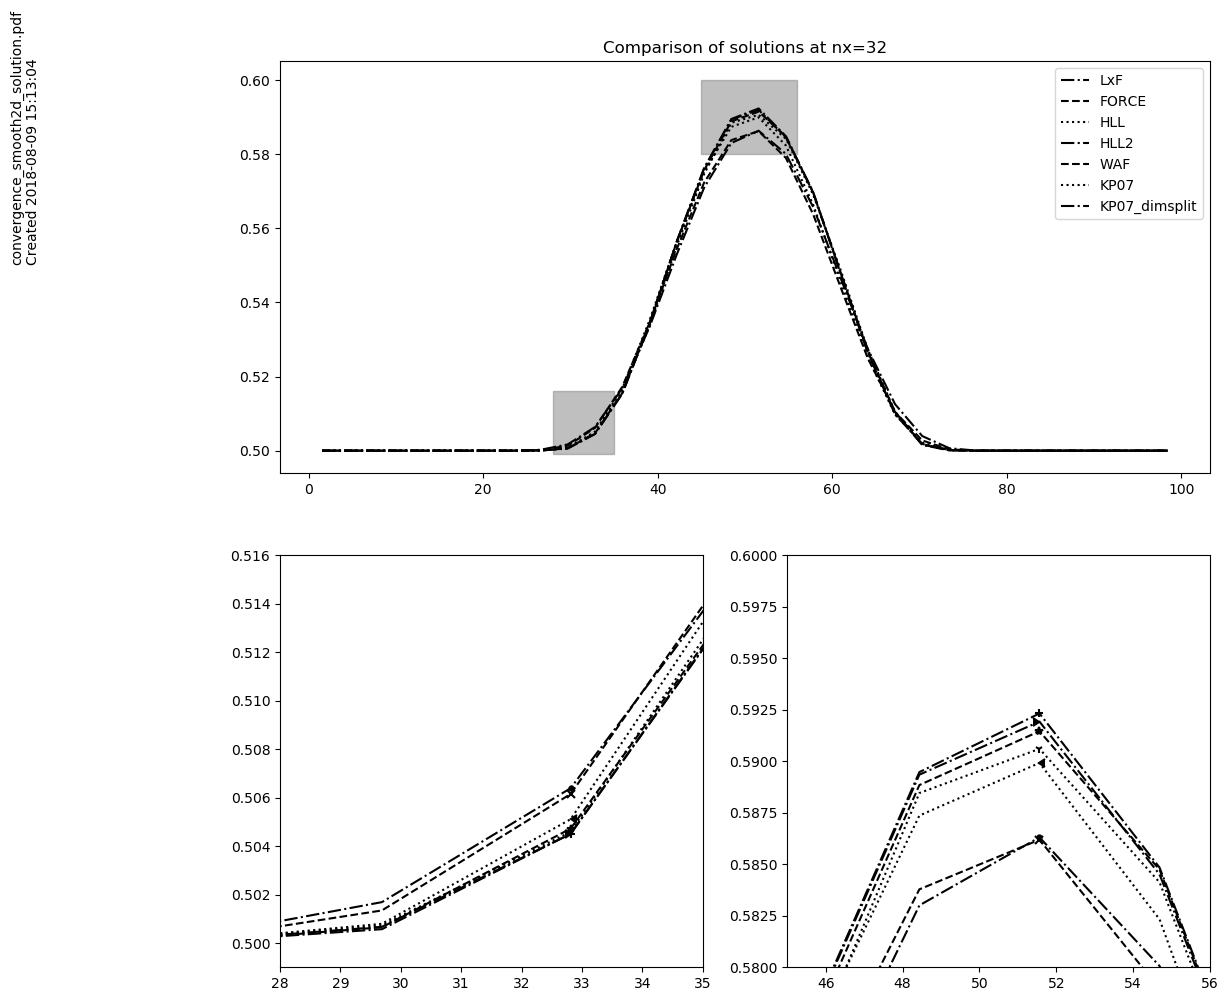

In [15]:
boxes = np.array([\
         [[28, 35], [0.499, 0.516]], \
         [[45, 56], [0.58, 0.60]]
         ])
comparison_nx = 32

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of solutions at nx=" + str(comparison_nx))
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim(boxes[0, 0])
plt.ylim(boxes[0, 1])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim(boxes[1, 0])
plt.ylim(boxes[1, 1])
    
save_figure(fig, 'solution')

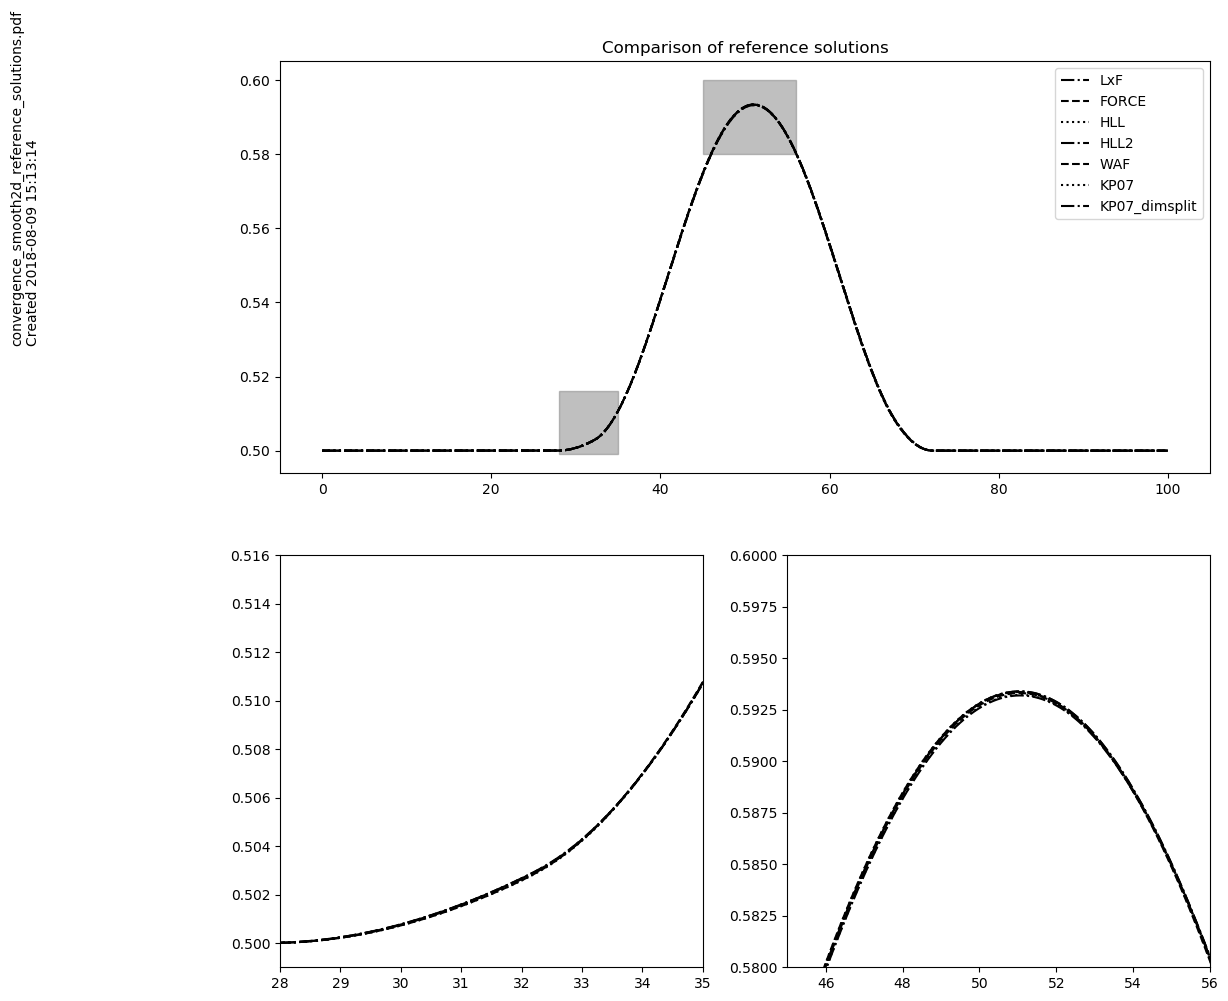

In [16]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of reference solutions")
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim(boxes[0, 0])
plt.ylim(boxes[0, 1])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim(boxes[1, 0])
plt.ylim(boxes[1, 1])
    
save_figure(fig, 'reference_solutions')

In [ ]:
boxes = np.array([\
         [[28, 35], [0.499, 0.516]], \
         [[45, 56], [0.58, 0.60]]
         ])

for simulator in simulators:
    fig = plt.figure(figsize=(12, 12))
    
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = fig.add_subplot(gs[0,:])
    setBwStyles(ax1)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')
    for box_x, box_y in boxes:
        x = np.kron(box_x, np.ones((2)))
        y = np.hstack((box_y, box_y[::-1]))
        fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
    plt.title(str(simulator.__name__))
    plt.legend()
    
    ax2 = fig.add_subplot(gs[1,0])
    setBwStyles(ax2)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')  
    plt.xlim(boxes[0, 0])
    plt.ylim(boxes[0, 1])
    
    ax3 = fig.add_subplot(gs[1,1])
    setBwStyles(ax3)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')   
    plt.xlim(boxes[1, 0])
    plt.ylim(boxes[1, 1])
    
    save_figure(fig, simulator.__name__)